## `ndarray` Object Internals

The `ndarray` is more than just a chunk of memory and a dtype; it also has “striding” information that enables the array to move through memory with varying step sizes. More precisely, the ndarray internally consists of the following:
- A **pointer to data**: that is, a block of data in RAM or in a memory-mapped file
- The data type or `dtype`, describing fixed-size value cells in the array
- A tuple indicating the array’s `shape`
- A tuple of `strides`, integers indicating the number of bytes to “step” in order to advance one element along a dimension.

While it is rare that a typical NumPy user would be interested in the array strides, they are the critical ingredient in constructing “zero-copy” array views.

## Order in `reshape`, `ravel` and `flatten`

`reshape` and `ravel`/`flatten` change the shape of `ndarray`. The subtle point here is that `reshape` and `ravel` also take an `order` argument that determines whether to traverse higher dimension first or last.
- C/row major order

    Traverse higher dimension first. For instance, for `reshape` it divides up all elements by the first dimension first.
    
    
- Fortran/column major order

    Traverse higher dimension last. For instance, for `reshape` it divides up all elements by the first dimension last.
    
Also, in `reshape`, **one can use $-1$ to infer unspecified dimensions**.

Another subtle point about `reshape` is that **it just simply returns the object using the same address as the original one**. So **changing the reshaped array will affect the original one as well**.

In [1]:
import numpy as np
arr = np.arange(10)
arr.reshape(2, -1)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [8]:
# rank items in a multidimensional array using numpy
a = np.random.randint(20, size=[2,5])
print(a)
print(a.ravel().argsort().argsort().reshape(a.shape))

[[ 6 18  6 17 19]
 [10  3 16  3  1]]
[[3 8 4 7 9]
 [5 1 6 2 0]]


## Broadcasting

Broadcasting describes how arithmetic works between arrays of different shapes. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. **Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. It does this without making needless copies of data and usually leads to efficient algorithm implementations**.

The Broadcasting Rule is the following. Two arrays are compatible for broadcasting if **for each trailing dimension (i.e., starting from the end) the axis lengths match or if either of the lengths is $1$**. Broadcasting is then **performed over the missing or length $1$ dimensions**. To facilitate conforming with this rule, `numpy` offers a special syntax for inserting new axes by indexing: the special `np.newaxis` attribute along with “full” slices to insert the new axis.

The same broadcasting rule governing arithmetic operations **also applies to setting values via array indexing**.

In [1]:
import numpy as np
arr = np.zeros((4, 3))
col = np.array([1.28, -0.42, 0.44, 1.6])
arr[:] = col[:, np.newaxis]
print(arr)
arr[:2] = [[-1.37], [0.509]]
print(arr)

[[ 1.28  1.28  1.28]
 [-0.42 -0.42 -0.42]
 [ 0.44  0.44  0.44]
 [ 1.6   1.6   1.6 ]]
[[-1.37  -1.37  -1.37 ]
 [ 0.509  0.509  0.509]
 [ 0.44   0.44   0.44 ]
 [ 1.6    1.6    1.6  ]]


In [6]:
# Create a new column for volume in iris_2d, where volume is (pi x petallength x sepal_length^2)/3
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_2d = np.genfromtxt(url, delimiter=',', dtype='object')
names = ('sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'species')

sepallength = iris_2d[:, 0].astype('float')
petallength = iris_2d[:, 2].astype('float')
volume = (np.pi * petallength * sepallength ** 2) / 3
# print(volume)
volume = volume[:, np.newaxis] # to match the dimension of iris_2d
# print(volume)
out = np.hstack([iris_2d, volume])
print(out[:4])

[[b'5.1' b'3.5' b'1.4' b'0.2' b'Iris-setosa' 38.13265162927291]
 [b'4.9' b'3.0' b'1.4' b'0.2' b'Iris-setosa' 35.200498485922445]
 [b'4.7' b'3.2' b'1.3' b'0.2' b'Iris-setosa' 30.0723720777127]
 [b'4.6' b'3.1' b'1.5' b'0.2' b'Iris-setosa' 33.238050274980004]]


In [9]:
# subtract the 1d array b_1d from the 2d array a_2d, such that each item of b_1d subtracts from respective row of a_2d
a_2d = np.array([[3,3,3],[4,4,4],[5,5,5]])
b_1d = np.array([1,2,3])
a_2d - b_1d[:, np.newaxis]

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

## Advanced *ufunc* Usage

Again, the motivation to make use of these *ufunc*s is to avoid otherwise necessary `for` loop in python. Some of the common ones are as follows.
- `reduce` takes a single array and aggregates its values, optionally along an axis, by performing a sequence of binary operations. If an `axis` is passed, the reduction is performed along that axis (as with many other aggregate type of funcions in `numpy`)
- `accumulate` is related to reduce like cumsum is related to sum. It produces an array of the same size with the intermediate 'accumulated' value. Similar treatment on the optional `axis` argument.
- `outer` performs a pairwise cross-product between two arrays. The output of outer will have a dimension that is the sum of the dimensions of the inputs.
- `reduceat`, performs a “local reduce,” in essence an array groupby operation in which slices of the array are aggregated together. It accepts a sequence of 'bin edges' of indices that indicate how to split and aggregate the values

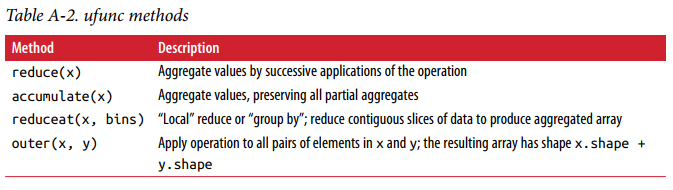

`numpy` also supports user-defined ufuncs, and the most general is to use the Numpy C API. 

It is possible to define pure Python ufuncs that works on scaler value and carry over to vector as well, using `np.frompyfunc` or `np.vectorize`, but they may not be efficient.

In [ ]:
arr = np.arange(10)
np.add.reduce(arr)

arr = np.arange(15).reshape((3, 5))
np.add.accumulate(arr, axis=1)

x, y = np.random.randn(3, 4), np.random.randn(5)
result = np.subtract.outer(x, y)
print(result.shape)

## Performance Tips

- Convert Python loops and conditional logic to array operations and boolean
array operations
- Use broadcasting whenever possible
- Use arrays views (slicing) to avoid copying data
- Utilize ufuncs and ufunc methods

## Reference

- [< Python for Data Analysis >](https://www.evernote.com/shard/s191/nl/21353936/86678e4b-3f5b-43e1-9e6a-c1fb0dcb7435?title=Python%20for%20Data%20Analysis), ed2, Appendix A.
- [< 101 numpy exercises >](https://www.machinelearningplus.com/python/101-numpy-exercises-python/)